# Exploração de algoritmos de classificação baseado em Bag of Features

## Alunos

    Lucas Resende Pellegrinelli Machado
    Victor Hugo Silva Moura

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os.path

np.random.seed(0)

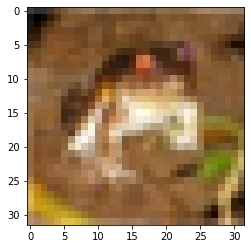

In [2]:
from sklearn.preprocessing import OneHotEncoder

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convertendo os ys para one hot encoding
y_train_oh = OneHotEncoder().fit_transform(y_train).toarray()
y_test_oh = OneHotEncoder().fit_transform(y_test).toarray()

plt.imshow(x_train[0])

## Definição dos métodos auxiliares para a criação dos histogramas

Na célula abaixo temos as funções ```train_kmeans_model``` que a partir das imagens de treino e os descritores de cada uma delas gera um modelo ```KMeans``` do sklearn treinado com esses dados. Também temos ```calculate_image_histograms``` que a partir do modelo criado pela função citada previamente e imagens de entrada, encontra os clusters dos descritores dessas imagens e retorna um histograma de descritores para cada imagem.

In [3]:
from sklearn.cluster import KMeans

def get_feature_image(image, keypoint):
    minx = int(keypoint.pt[0] - keypoint.size // 2)
    maxx = int(keypoint.pt[0] + keypoint.size // 2 + 1)
    miny = int(keypoint.pt[1] - keypoint.size // 2)
    maxy = int(keypoint.pt[1] + keypoint.size // 2 + 1)
    return image[minx : maxx, miny : maxy]

def train_kmeans_model(input_images, descriptor_fit_count, cluster_count):
    fast = cv2.FastFeatureDetector_create()
    sift = cv2.SIFT_create()
    kmeans_model = KMeans(n_clusters=cluster_count, random_state=0)

    all_descriptors = []
    for raw_input_image in input_images:
        input_image = cv2.cvtColor(raw_input_image, cv2.COLOR_RGB2GRAY)
        keypoints = fast.detect(input_image, None)
        keypoints, descriptors = sift.compute(input_image, keypoints)
        if descriptors is not None:
            all_descriptors.extend(descriptors)
    
    shuffled_descriptors = np.copy(all_descriptors)
    np.random.shuffle(shuffled_descriptors)
    kmeans_model.fit(shuffled_descriptors[:descriptor_fit_count])
    return kmeans_model

def calculate_image_histograms(input_images, kmeans_model, preview_clusters=False):
    fast = cv2.FastFeatureDetector_create()
    sift = cv2.SIFT_create()
    
    histograms = []
    all_cluster_images = [[] for _ in range(len(kmeans_model.cluster_centers_))]
    for raw_input_image in input_images:
        input_image = cv2.cvtColor(raw_input_image, cv2.COLOR_RGB2GRAY)
        keypoints = fast.detect(input_image, None)
        keypoints, descriptors = sift.compute(input_image, keypoints)
        histogram = [0 for _ in range(len(kmeans_model.cluster_centers_))]
        if descriptors is not None:
            clusters = kmeans_model.predict(descriptors)
            for c in clusters: histogram[c] += 1
            if preview_clusters:
                for kp, cluster in zip(keypoints, clusters):
                    feature_img = get_feature_image(input_image, kp)
                    all_cluster_images[cluster].append(feature_img)
                
        histograms.append(histogram)
        
    if preview_clusters:
        for c in range(5):
            print("Cluster #" + str(c))
            fig, axs = plt.subplots(1, 8, figsize=(18, 5))
            for i in range(8):
                axs[i].set_axis_off()
                axs[i].imshow(all_cluster_images[c][i], cmap="gray")
            plt.show()
        
    return np.array(histograms)

## Definição de funções auxiliares para a criação de modelos

Abaixo temos a definição dos métodos que inicializam modelos de aprendizado. Os dois modelos são os requeridos pela especificação do trabalho:

 - **Random Forest**: Escolhemos um número de estimadores igual a 128 pois gerou uma boa relação entre resultados e tempo de execução.
 - **Rede Neural**: É uma rede simples de 3 camadas escondidadas com valores que geraram resultados bons nos testes preliminares. Para evitar problemas com overfitting também foram adicionadas camadas ```Dropout``` como regularizadores.

In [4]:
from sklearn.ensemble import RandomForestClassifier

def build_neural_network(input_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, input_shape=(input_size,), activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

def build_random_forest():
    return RandomForestClassifier(n_estimators=128, random_state=0)

## Definição da função principal

Abaixo temos a função que gera as estatísticas para um dos tamanhos de dicionário específico. Ela recebe os dados de treino e validação assim como um modelo já treinado (pela função ```train_kmeans_model``` definida anteriormente) e retorna estatísticas (acurácia e matriz de confusão) tanto dos resultados do algoritmo de Random Forest como da rede neural criada.

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix

def calculate_stats(train_data, test_data, kmeans_model):
    # Calculating histograms for each dataset
    train_histograms = calculate_image_histograms(x_train, kmeans_model)
    test_histograms = calculate_image_histograms(x_test, kmeans_model)
    print(" - Finished calculating histograms")
    
    # Fitting random forest
    random_forest_model = build_random_forest()
    random_forest_model.fit(train_histograms, y_train.flatten())
    print(" - Finished fitting random forest")
    
    # Fitting neural network
    nn_model = build_neural_network(train_histograms.shape[1])
    nn_model.fit(train_histograms, y_train_oh, batch_size=128, epochs=20, verbose=0, validation_data=(test_histograms, y_test_oh))
    print(" - Finished fitting neural network")
    
    # Getting output from random forest
    train_rf_pred = random_forest_model.predict(train_histograms)
    test_rf_pred = random_forest_model.predict(test_histograms)
    print(" - Finished prediction with random forest")
    
    # Getting output from neural network
    train_nn_pred = np.argmax(nn_model.predict(train_histograms), axis=1)
    test_nn_pred = np.argmax(nn_model.predict(test_histograms), axis=1)
    print(" - Finished prediction with neural network")
    
    return {
        "random-forest": {
            "train": {
                "accuracy": accuracy_score(y_train, train_rf_pred),
                "confusion": confusion_matrix(y_train, train_rf_pred)
            },
            "test": {
                "accuracy": accuracy_score(y_test, test_rf_pred),
                "confusion": confusion_matrix(y_test, test_rf_pred)
            }
        },
        "neural-network": {
            "train": {
                "accuracy": accuracy_score(y_train, train_nn_pred),
                "confusion": confusion_matrix(y_train, train_nn_pred)
            },
            "test": {
                "accuracy": accuracy_score(y_test, test_nn_pred),
                "confusion": confusion_matrix(y_test, test_nn_pred)
            }
        }
    }

## Loop principal

Abaixo temos o loop que chama a função ```calculate_stats``` para os diferentes tamanhos de dicionário.

In [6]:
stats = {}
for n_dictionaries in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    print("Exploring number of dictionaries =", n_dictionaries)
    kmeans_model = train_kmeans_model(x_train, 10000, n_dictionaries)
    print(" - Finished fitting KMeans")
    stats[n_dictionaries] = calculate_stats(x_train, x_test, kmeans_model)

Exploring number of dictionaries = 100
 - Finished fitting KMeans
 - Finished calculating histograms
 - Finished fitting random forest
 - Finished fitting neural network
 - Finished prediction with random forest
 - Finished prediction with neural network
Exploring number of dictionaries = 200
 - Finished fitting KMeans
 - Finished calculating histograms
 - Finished fitting random forest
 - Finished fitting neural network
 - Finished prediction with random forest
 - Finished prediction with neural network
Exploring number of dictionaries = 300
 - Finished fitting KMeans
 - Finished calculating histograms
 - Finished fitting random forest
 - Finished fitting neural network
 - Finished prediction with random forest
 - Finished prediction with neural network
Exploring number of dictionaries = 400
 - Finished fitting KMeans
 - Finished calculating histograms
 - Finished fitting random forest
 - Finished fitting neural network
 - Finished prediction with random forest
 - Finished prediction 

## Funções de plotting

Abaixo temos o plot dos resultados de acurácia para cada tamanho de dicionário.

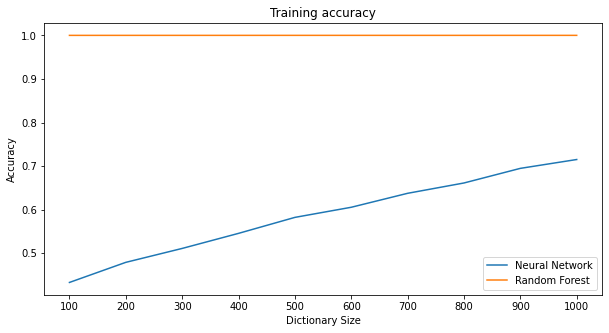

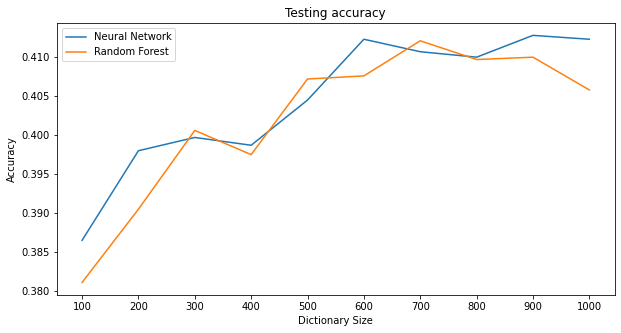

In [7]:
nn_test_acc = []
nn_train_acc = []
rf_test_acc = []
rf_train_acc = []
x_values = []

for key, value in stats.items():
    x_values.append(key)
    nn_test_acc.append(value["neural-network"]["test"]["accuracy"])
    nn_train_acc.append(value["neural-network"]["train"]["accuracy"])
    rf_test_acc.append(value["random-forest"]["test"]["accuracy"])
    rf_train_acc.append(value["random-forest"]["train"]["accuracy"])
    
plt.figure(figsize=(10, 5))
plt.title("Training accuracy")
plt.plot(x_values, nn_train_acc, label="Neural Network")
plt.plot(x_values, rf_train_acc, label="Random Forest")
plt.xticks(x_values)
plt.xlabel("Dictionary Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()
    
plt.figure(figsize=(10, 5))
plt.title("Testing accuracy")
plt.plot(x_values, nn_test_acc, label="Neural Network")
plt.plot(x_values, rf_test_acc, label="Random Forest")
plt.xticks(x_values)
plt.xlabel("Dictionary Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

## Estatísticas do melhor resultado

In [11]:
print("Best Neural Network Training Report")
print(" - Accuracy =", stats[900]["neural-network"]["train"]["accuracy"], "%")
print(" - Confusion matrix:")
print(stats[900]["neural-network"]["train"]["confusion"])
print("\n")
print("Best Neural Network Validation Report")
print(" - Accuracy =", stats[900]["random-forest"]["test"]["accuracy"], "%")
print(" - Confusion matrix:")
print(stats[900]["random-forest"]["test"]["confusion"])

Best Neural Network Training Report
 - Accuracy = 0.69482 %
 - Confusion matrix:
[[3978  121  184   45   56   30   25   74  381  106]
 [ 107 4040   10   38   27   18   87   46  289  338]
 [ 264   66 3205  315  230  357  193  210   86   74]
 [  95   96  320 2634  186  870  257  284   75  183]
 [ 142  128  464  194 2679  311  317  588  100   77]
 [  20   52  217  737  117 3211  218  325   38   65]
 [  54  123  152  278  177  239 3625  145   74  133]
 [  58   51  168  142  209  236   76 3903   44  113]
 [ 492  365   52   28   37   28   52   33 3820   93]
 [ 116  709   37   47   23   32  116   97  177 3646]]


Best Neural Network Validation Report
 - Accuracy = 0.41 %
 - Confusion matrix:
[[470  61  91  23  38  17  32  35 182  51]
 [ 52 493  20  15  29  11  45  16 142 177]
 [ 97  39 368  80  87 133  60  43  48  45]
 [ 34  32 112 230  80 229  76 103  32  72]
 [ 56  60 124  63 289 113  78  98  57  62]
 [ 22  15 134 141  66 400  78  84  20  40]
 [ 28  69  77  87  95  97 392  56  23  76]
 [ 37

## Conclusão

O algoritmo bag of words foi implementado com sucesso e os resultados obtidos forem bem interessantes ficando por volta de 40% de acurácia com um método que não utiliza nenhuma informação da imagem diretamente. Os métodos de aprendizado comparados não geraram resultados muito diferentes, mostrando que em certos casos não existe necessidade de explorarmos métodos mais complexos como redes neurais quando métodos clássicos conseguem resultados muito parecidos.